# Path planning notebook

In [23]:
import cv2
import matplotlib.pyplot as plt
import json
import numpy as np
import sys

sys.path.append("..")

from src.vision import VisionDetector

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's present the global navigation pipeline with the following sample image, where the robot is represented by the marker in the center :

<div style="text-align: center;">
    <img src="../assets/additional/path_planning.png" alt="Title" width="350"/>
</div>

In [2]:
from src.path_planning import create_adjacency_matrix, create_obstacle_map, path_planning
from src.utils import add_graph, add_route, add_circles, add_polygons, add_point
from src.vision import extend_polygons
import inspect

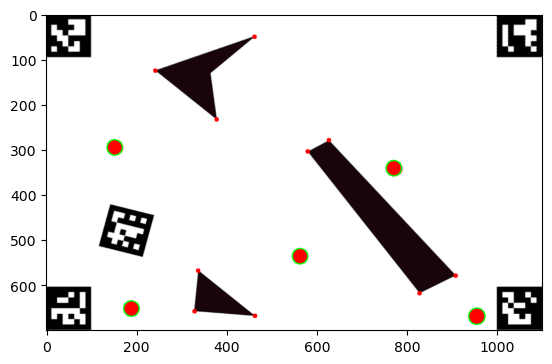

In [3]:
circle_balises = cv2.imread('../assets/additional/aruco_balises_circles_perspective.png')
aruco_info = json.load(open('../assets/aruco/state.json', 'r'))
detector = VisionDetector(circle_balises, (1100, 700), **aruco_info)
img_corrected = detector.get_corrected_image(circle_balises, hide_aruco=False)
circles = detector.find_circles(img_corrected, 1, 300, 300, 30)
polygons = detector.find_polygons(img_corrected)
processed_image = add_circles(img_corrected, circles)
processed_image = add_polygons(processed_image, polygons)
plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))

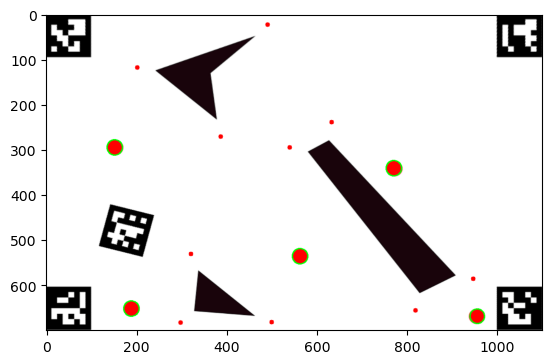

In [4]:
robot_size = 40
polygons, circles = detector.find_shapes(img_corrected, border_size=10)
extended_polygons = extend_polygons(polygons, robot_size)

poly_image = add_polygons(img_corrected, extended_polygons)
circle_image = add_circles(poly_image, circles)
plt.imshow(cv2.cvtColor(circle_image, cv2.COLOR_BGR2RGB))

This allows us to extract an array of map key points. These keypoints represent the set of polygon vertices, target circles and the robot itself.

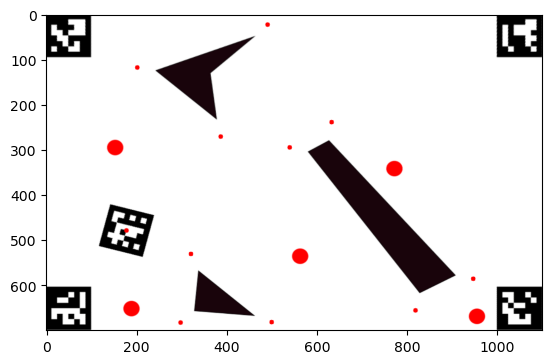

In [5]:
robot_position, _, _ = detector.get_robot_pose(img_corrected, is_corrected=True)
more_circled_img = add_point(poly_image, np.array([robot_position[0], robot_position[1]]))
plt.imshow(cv2.cvtColor(more_circled_img, cv2.COLOR_BGR2RGB))

To create the optimal path, we will look at the set of paths that exclusively contain straight lines between keypoints.

To compute such a path, we need to create a graph of keypoints where two points are joined by an edge if and only if they are mutually visible, ie the line that joins the two points doesn't get to close to an obstacle.

When an edge exists, we give it a weight that is the distance between the two corresponding vertices.

We will mathematically represent the graph as an adjacency matrix $A$, with an index map of the keypoint, keeping track of the indices of the robot and target points.
The matrix $A$ will contain the weights $a_{i, j}$ of each edge. By convention, we will set the weigh to $0$ when the points are not mutually visible.

To create the adjacency matrix of the graph, we loop over all pairs of key points, check whether the two points are mutually visible and set the associated value in the adjacency matrix to the distance between the two points.

To check if two points are mutually visible, we will combine:
- The bresenham algorithm: An algorithm that computes the pixel positions of the rasterized line between two given pixels
- An obstacle map: A bitmap of the filled extended polygons.

Two points will be mutually visible if and only if all points on the rasterized line between them are not obstacle points. Because of rasterization which spills on neighbouring pixels, we also decided to not concider the first and last 10 pixels of the line.

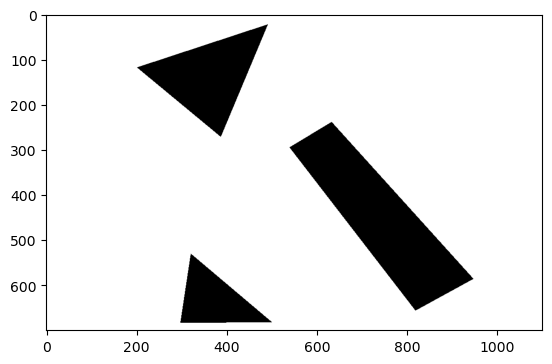

In [6]:
obstacle_map = create_obstacle_map(extended_polygons, img_corrected.shape)
plt.imshow(obstacle_map, cmap='gray')

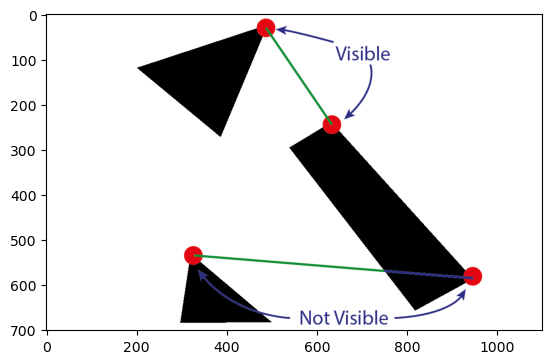

In [7]:
plt.imshow(cv2.cvtColor(cv2.imread("../assets/report_pics/computer_vision/visibility.png"), cv2.COLOR_BGR2RGB))

In [15]:
from bresenham import bresenham
from src.path_planning import is_visible
print(inspect.getsource(is_visible))

def is_visible(p1, p2, obstacle_map): 
    """
    This function checks if we can reach p2 from p1 without colliding with the obstacle map.
    We first compute the equation of the line segment between p1 and p2.
    Then we check at each pixel along the line segment if it is part of an obstacle given the obstacle map.
    """
    # check if p1 and p2 are inside of the map
    if not in_image(p1, obstacle_map) or not in_image(p2, obstacle_map):
        return False
    
    line = list(bresenham(int(p1[0]), int(p1[1]), int(p2[0]), int(p2[1])))
    line = line[10:-10] # remove the start and end points
    for point in line:
        if obstacle_map[point[1], point[0]] == 0:
            return False
    
    return True



Text(0.5, 1.0, 'Bresenham rasterized line between two points')

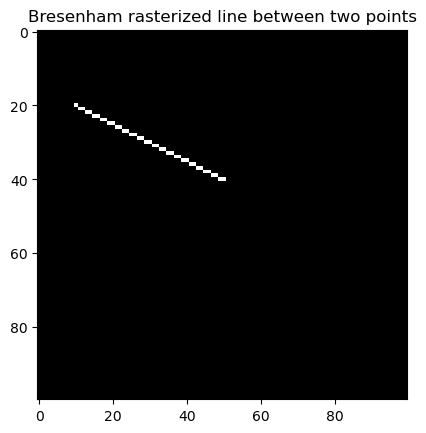

In [16]:
# plot a line between two points
new_image = np.zeros((100, 100))
p1 = (10, 20)
p2 = (50, 40)
line = bresenham(*p1, *p2)
for x, y in line:
    new_image[y, x] = 1
plt.imshow(new_image, cmap='gray')
plt.title('Bresenham rasterized line between two points')

In [17]:
from src.path_planning import create_adjacency_matrix_pts
print(inspect.getsource(create_adjacency_matrix_pts))

def create_adjacency_matrix_pts(points, obstacle_map):
    """
    Creates an adjacency matrix for the graph formed by the points.
    If the points are visible to each other, then the edge value is the euclidean distance between the points.
    Otherwise, their is no edge between the points.
    """
    n = points.shape[0]
    adjacency_matrix = np.zeros((n, n))

    l = np.arange(n)

    for n1 in range(len(points)):
        for n2 in range(n1+1, len(points)):
            p1 = points[n1]
            p2 = points[n2]
            if is_visible(p1, p2, obstacle_map):
                edge_value = np.linalg.norm(p1 - p2)
                adjacency_matrix[n1, n2] = edge_value
                adjacency_matrix[n2, n1] = edge_value
    return adjacency_matrix



In practice, the adjacency matrix will be computed in two steps.
1. The first step is to run the previous strategy between all pair of points. But this strategy won't include any line segment that spans across the obstacle polygon's vertices, although it is a valid edge, the visibility check will detect obstacles.
2. The second step is therefore to add the edges of each polygons into the adjacency matrix. But we must be careful when doing so as these edges could cross an other polygon's extention. Therefore, the strategy that is employed is to recompute, for each polygon, a new obstacle map not containing that polygon and adding the edge to the adjacency matrix only if the edge vertices are visible in the new obstacle map.

Here is the implementation of the full adjacency matrix pipeline:

In [18]:
from src.path_planning import create_adjacency_matrix
print(inspect.getsource(create_adjacency_matrix))

def create_adjacency_matrix(polygons, start_position, key_points, img_shape):
    """
    Creates an adjacency matrix for the graph formed by the points in the polygons. Note that here, we may use this function with the
    polygons as well as the start position, and key points.
    The adjacency matrix is created by connecting the points which are visible.
    """
    poly_list = polygons.copy()
    poly_list.append(start_position[None, None, :])
    poly_list.extend([kp[None, None, :] for kp in key_points])

    obstacle_map = create_obstacle_map(poly_list, img_shape)
    points = [[*polygon.squeeze(1)] for polygon in poly_list]
    points = np.concatenate(points)

    adjacency_matrix = create_adjacency_matrix_pts(points, obstacle_map)
    
    # adding edges of polygons to the adjacency matrix
    n_buffer = 0
    for n_poly, polygon in enumerate(polygons):
        polygon = polygon.squeeze(1)
        n = polygon.shape[0]
        for i in range(n):
            if not in_image(polyg

We can display the complete adjacency graph, which we will explore to compute the shortest path collecting all objectives from the robot's initial position

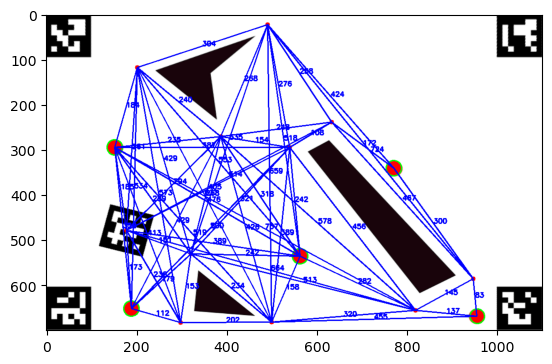

In [20]:
polygons = detector.find_polygons(img_corrected)
extended_polygons = extend_polygons(polygons, robot_size)
robot_position, _, _ = detector.get_robot_pose(img_corrected, is_corrected=True)
circles = detector.find_circles(img_corrected, 1, 300, 300, 30)
circle_positions = circles.squeeze()[:, :2]
img_shape = img_corrected.shape[:2]
adjacency_matrix, points = create_adjacency_matrix(extended_polygons, robot_position, circle_positions, img_shape)

graph_image = add_graph(circle_image, np.uint32(points), adjacency_matrix, color=(255, 0, 0))
plt.imshow(cv2.cvtColor(graph_image, cv2.COLOR_BGR2RGB))

Shortest path computation 

The shortest path is computed in two steps.

1. We start by creating a dictionary, whose keys are pairs of circle targets, as well as the robot. For each key, we will compute, in the adjacency matrix that we created, the shortest path between the two points. The dictionary values may contain the length of the path as well as the sequence of vertex ids that represent the path. This step is executed using Dijkstra's algorithm.
2.  Once this is computed, our goal is to find the shortest path that visits all the key points from the start position.
We can loop over all possible permutations of the circle targets, compute the cost of the associated paths, as the sum of the lengths of successive pairs in the permutation.
The final cost must also include the cost of going from the start position to the first key point. To this cost, we add the cost of going from the robot to the first objective.
We then select the path with the minimum cost.
The final path will be te concatenation of the successive shortest paths between each target.

Although this method is quite brute force, it works perfectly and in real time for our usecase as the number of key points and targets is small. 

Here is the computed path:

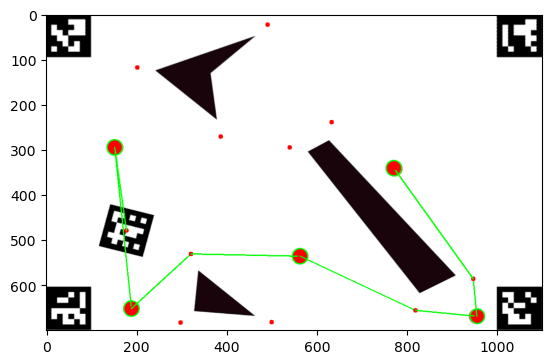

In [ ]:
optimal_route, optimal_route_positions, points, adjacency_matrix = path_planning(robot_position, circle_positions, extended_polygons, processed_image.shape)
route_image = add_route(circle_image, np.int32(optimal_route_positions))
plt.imshow(cv2.cvtColor(route_image, cv2.COLOR_BGR2RGB))

We can also take a look at the optimal path with the obstacle map, and convince ourselves that it is indeed the shortest possible path that reaches all targets!

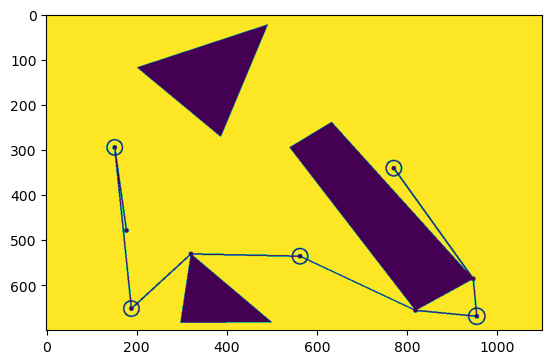

In [21]:
obstacle_map = create_obstacle_map(extended_polygons, processed_image.shape)
circled = add_circles(obstacle_map, circles)
route_image = add_route(circled, np.int32(optimal_route_positions))
plt.imshow(circled)